In [1]:
import pickle
import numpy as np

bsnipdir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/BSNIP/'
bsnipdemo = pickle.load(open(f'{bsnipdir}/demographics.pkl', 'rb'))
bsniptopdir = '/home/anton/Documents/Tulane/Research/Work/ContrastiveLearning/BSNIP/'

fc = []
aps20 = []
aps15 = []
aps10 = []
aps5 = []
aps3 = []
aps1 = []
age = []
sex = []
race = []
sz = []

for sub in bsnipdemo['Age_cal']:
    try:
        a = bsnipdemo['Age_cal'][sub]
        s = bsnipdemo['sex'][sub]
        r = bsnipdemo['Race'][sub]
        d = bsnipdemo['DXGROUP_1'][sub]
        if d not in ['NC', 'SZP']:
            continue
        if r not in ['AA', 'CA']:
            continue
        s = s == 's1.0'
        r = r == 'AA'
        d = d == 'SZP'
        age.append(a)
        sex.append(s)
        race.append(r)
        sz.append(d)
        fc.append(np.load(f'{bsnipdir}/fc/{sub}_task-unk_fc.npy'))
        aps20.append(np.load(f'{bsniptopdir}/Top20/{sub}_task-unktop20_fc.npy'))
        aps3.append(np.load(f'{bsniptopdir}/Top3/{sub}_task-unktop3_fc.npy'))
        aps1.append(np.load(f'{bsniptopdir}/Top1/{sub}_task-unktop1_fc.npy'))
    except:
        pass

age = np.stack(age)
sex = np.stack(sex).astype('int')
race = np.stack(race).astype('int')
sz = np.stack(sz).astype('int')
fc = np.stack(fc)
aps20 = np.stack(aps20)
aps1 = np.stack(aps1)

print([x.shape for x in [age, sex, race, sz, fc, aps20, aps1]])

[(405,), (405,), (405,), (405,), (405, 34716), (405, 34716), (405, 34716)]


In [63]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split

def rmse(yhat, y):
    return np.mean((yhat-y)**2)**0.5

accs = []
nulls = []

for i in range(10):
    # Try mixup
    
    idcs = np.random.permutation(len(aps1))
    mixed = aps20-0.2*aps1+0.2*aps1[idcs]
    
    xtr, xt, ytr, yt = train_test_split(mixed, sex, stratify=sex, train_size=0.8)

    # reg = Ridge(alpha=1).fit(xtr, ytr)
    # yhat = reg.predict(xt)
    # acc = rmse(yhat, yt)
    # null = rmse(np.mean(ytr), yt)
    # print(acc, null)

    reg = LogisticRegression(C=1, max_iter=1000).fit(xtr, ytr)
    yhat = reg.predict(xt)
    acc = np.mean(yhat == yt)
    null = np.mean(yt)
    if null < 0.5:
        null = 1-null
    print(acc, null)

    accs.append(acc)
    nulls.append(null)

print('---')
print(np.mean(accs))
print(np.mean(nulls))

0.7530864197530864 0.5432098765432098
0.7283950617283951 0.5432098765432098
0.7037037037037037 0.5432098765432098
0.6666666666666666 0.5432098765432098
0.654320987654321 0.5432098765432098
0.654320987654321 0.5432098765432098
0.6666666666666666 0.5432098765432098
0.7160493827160493 0.5432098765432098
0.7654320987654321 0.5432098765432098
0.6419753086419753 0.5432098765432098
---
0.6950617283950618
0.5432098765432098


In [15]:
# Find empirical mutual information

from sklearn.metrics.pairwise import euclidean_distances

N = len(fc)

x = np.random.normal(size=(N, 34716))
x = x - np.mean(x, axis=0, keepdims=True)
dx = euclidean_distances(x)
dx = dx[dx > 0.001]
sx = 0.5*np.std(dx)
mx = np.mean(dx)
print(sx, mx)

y = age
y = np.expand_dims(y - np.mean(y), 1)
dy = euclidean_distances(y)
sy = 0.5*np.std(dy)
my = np.mean(dy)
print(sy, my)

p = 0

for i in range(N):
    xi = x[i:i+1]
    yi = y[i:i+1]
    dxi = euclidean_distances(xi, x)
    a = dxi < (mx-sx)
    dyi = euclidean_distances(yi, y)
    b = dyi < (my-sy)
    c = a*b
    p += np.sum(c)/N*np.log(np.sum(c)*N/np.sum(b)/np.sum(a))
    if i%100 == 0:
        print(f'Done {i} {p}')

print(p)

0.5032572447685625 263.507974236799
5.103633094726715 14.147258039932938
Done 0 -0.004614693493176097
Done 100 0.09279225175117582
Done 200 0.26742741130362757
Done 300 0.7825525144876874
Done 400 1.293989682861806
1.3043495563134866


# Mutual Information

# Age (0.5)
- 11.755405915034213 random Gaussian 0.3735671523531771
- 118.9762486869882 fc 2.61858270420694
- 104.68006537485854 aps1 1.2641682715702864
- 119.18789027121039 aps20 2.6028671758169617
- 131.84321219675988 aps20-aps1 2.885637896870981
- 129.9191387233695 fc-aps1 2.969903625761516

# Sex (0.5)
- 15.759411155635313 random Gaussian 0.29706147909883934
- 88.22025877472836 fc 0.9845530444062722
- 83.63518878322546 aps1 0.9064087426196122
- 87.60736797895963 aps20 1.10122155325856
- 91.47227217140231 aps20-aps1 1.2088244638428327
- 91.07479800444804 fc-aps1 1.2495701942241484

# Race (0.2)
- 5.341035232040504 random Gaussian 0.40922564293790803
- 95.139540984524 fc 2.851609568134919
- 81.286118602034 aps1 1.159043931239024
- 93.623680219314 aps20 2.939169131020231
- 100.14754383136 aps20-aps1 3.0256376703928836
- 101.42651103802069 fc-aps1 2.8998044102450873

# SZ (0.5)
- 11.48694228176085 random Gaussian 0.891294477018655
- 103.49155046290215 fc 4.064583415942344
- 86.22777580303065 aps1 2.3396928365342937
- 102.57837866447328 aps20 4.091555282694833
- 106.04889032464408 aps20-aps1 6.466207458998451
- 104.78782652922564 fc-aps1 6.5047088848540655

/tmp/ipykernel_87148/90364734.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


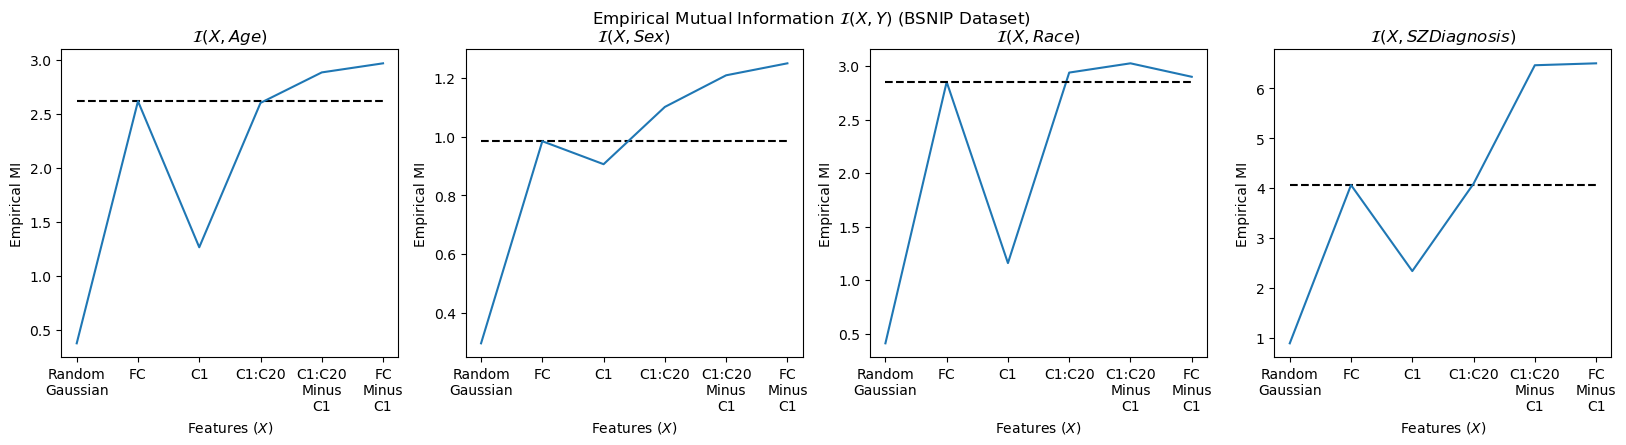

In [155]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,4,figsize=(20,4))

age = [0.3735671523531771, 2.61858270420694, 1.2641682715702864, 2.6028671758169617, 2.885637896870981, 2.969903625761516]
sex = [0.29706147909883934, 0.9845530444062722, 0.9064087426196122, 1.10122155325856, 1.2088244638428327, 1.2495701942241484]
race = [0.40922564293790803, 2.851609568134919, 1.159043931239024, 2.939169131020231, 3.0256376703928836, 2.8998044102450873]
sz = [0.891294477018655, 4.064583415942344, 2.3396928365342937, 4.091555282694833, 6.466207458998451, 6.5047088848540655]

labels = ['Random\nGaussian', 'FC', 'C1', 'C1:C20', 'C1:C20\nMinus\nC1', 'FC\nMinus\nC1']

ax[0].plot([0,5],[age[1],age[1]],linestyle='--',color='black')
ax[0].plot(labels, age)
ax[0].set_title('$\\mathcal{I}(X,Age)$')
ax[0].set_xlabel('Features ($X$)')
ax[0].set_ylabel('Empirical MI')

ax[1].plot([0,5],[sex[1],sex[1]],linestyle='--',color='black')
ax[1].plot(labels, sex)
ax[1].set_title('$\\mathcal{I}(X,Sex)$')
ax[1].set_xlabel('Features ($X$)')
ax[1].set_ylabel('Empirical MI')

ax[2].plot(labels, race)
ax[2].plot([0,5],[race[1],race[1]],linestyle='--',color='black')
ax[2].set_title('$\\mathcal{I}(X,Race)$')
ax[2].set_xlabel('Features ($X$)')
ax[2].set_ylabel('Empirical MI')

ax[3].plot([0,5],[sz[1],sz[1]],linestyle='--',color='black')
ax[3].plot(labels, sz)
ax[3].set_title('$\\mathcal{I}(X,SZ Diagnosis)$')
ax[3].set_xlabel('Features ($X$)')
ax[3].set_ylabel('Empirical MI')

fig.suptitle('Empirical Mutual Information $\\mathcal{I}(X,Y)$ (BSNIP Dataset)')
fig.show()
fig.savefig('/home/anton/Documents/Tulane/Research/Work/ContrastiveLearning/mutual_info_graph.pdf')

In [217]:
# Redo mutual information
# I(X,Y) = H(X)-H(X|Y)
# Bin using kmeans clustering

from sklearn.cluster import KMeans
import numpy as np

N = 25
inf = []

for j in range(50):
    x = fc-aps1
    x = np.random.normal(size=(len(fc), 34716))
    # x = np.stack([sex, race + 1*np.random.normal(size=len(fc))]).T
    # x = np.concatenate([x, np.random.normal(size=(len(fc), 1))], axis=1)
    y = sz
    hx = 0
    hxy = 0

    kmeans = KMeans(n_init='auto', n_clusters=N)
        
    kmeans.fit(x)

    for i in range(N):
        p = np.mean(kmeans.labels_ == i)
        if p == 0:
            continue
        hx += -p*np.log2(p)

    for k in range(2):
        py = np.mean(y == k)
        ky = kmeans.labels_[y == k]
        hh = 0

        for i in range(N):
            p = np.mean(ky == i)
            if p == 0:
                continue
            hh += -p*np.log2(p)
        
        hxy += py*hh

    print(hx, hxy)
    inf.append(hx - hxy)

print(np.mean(inf), np.std(inf))

4.21913260241796 4.177028989316238
3.979048241439824 3.952703115960168
4.226812118915562 4.174186354485755
4.358682185030324 4.323460496947867
4.072459560078049 4.017638122025298
4.3024045493357015 4.2631911561045195
3.965324316410328 3.922588162425108
3.650816981691037 3.6099704671337496
4.265123139867772 4.228995818121465
4.049376650922137 3.9962562080030244
4.208300552861095 4.142933559853752
4.2306265413505395 4.19295565882041
4.14226018753711 4.116528472604667
4.048785875322817 4.007334707322974
4.35700494897073 4.327038185123975
4.108439191703442 4.039702410852078
4.377733314294753 4.331229057990145
4.110492825756579 4.05846344677373
3.9472364750175135 3.8962090819980983
4.2455998988818155 4.199838519589385
3.399237148313476 3.3561684882338323
4.028235984735683 3.98464859368491
3.4250430897890056 3.3853469465884847
4.085552496821822 4.041632964843169
4.149998215770021 4.100617427556398
4.278457508501911 4.194739246965117
4.14629462377684 4.0958989153328345
3.8048981759849076 3.74